In [2]:
# Step 0: Scraper
import urllib
import re
from bs4 import BeautifulSoup
import os
import time
import random
from tika import parser
import string
from operator import itemgetter

In [20]:
def getFile(url):
    file_name = url.split('/')[-1]
    connection = urllib.request.urlopen(url)
    f = open(file_name, 'wb')

    block_sz = 8192
    while True:
        buffer = connection.read(block_sz)
        if not buffer:
            break

        f.write(buffer)
    f.close()
    connection.close()
    print ("Sucessful to download" + " " + file_name)

In [21]:
# Get web data from the url
url = "http://proceedings.mlr.press/v97/"
user_agent='Chrome/74.0.3729.169'
headers={'User-Agent':user_agent}
try:
    request = urllib.request.Request(url,headers=headers)
    data = urllib.request.urlopen(request).read().decode('utf-8')
except urllib.error.URLError as e:
    if hasattr(e,"code"):
        print (e.code)
    if hasattr(e,"reason"):
        print (e.reason)

soup = BeautifulSoup(data)

paper_list = soup.select('div#content div.paper')
pdf_download_list = []
for paper in paper_list:
    href_list = paper.select('p.links a')
    for href in href_list:
        if 'Download' in href.text:
            pdf_download_list.append(href['href'])

os.mkdir('pdf_download')
os.chdir(os.path.join(os.getcwd(), 'pdf_download'))
for pdf in pdf_download_list:
    getFile(pdf)
    time.sleep(10+random.random())

Sucessful to download feige19a.pdf
Sucessful to download feldman19a.pdf
Sucessful to download feraud19a.pdf
Sucessful to download fercoq19a.pdf
Sucessful to download finn19a.pdf
Sucessful to download fischer19a.pdf
Sucessful to download foerster19a.pdf
Sucessful to download fong19a.pdf
Sucessful to download franc19a.pdf
Sucessful to download franceschi19a.pdf
Sucessful to download freirich19a.pdf
Sucessful to download frerix19a.pdf
Sucessful to download frogner19a.pdf
Sucessful to download frosst19a.pdf
Sucessful to download fu19a.pdf
Sucessful to download fu19b.pdf
Sucessful to download fujii19a.pdf
Sucessful to download fujimoto19a.pdf
Sucessful to download gamrian19a.pdf
Sucessful to download ganea19a.pdf
Sucessful to download gao19a.pdf
Sucessful to download gao19b.pdf
Sucessful to download gao19c.pdf
Sucessful to download gao19d.pdf
Sucessful to download gao19e.pdf
Sucessful to download gao19f.pdf
Sucessful to download gazagnadou19a.pdf
Sucessful to download geifman19a.pdf
Sucessf

Sucessful to download lucic19a.pdf
Sucessful to download luise19a.pdf
Sucessful to download luo19a.pdf
Sucessful to download ma19a.pdf
Sucessful to download ma19b.pdf
Sucessful to download ma19c.pdf
Sucessful to download magnusson19a.pdf
Sucessful to download mahabadi19a.pdf
Sucessful to download maheswaranathan19a.pdf
Sucessful to download mahloujifar19a.pdf
Sucessful to download mahoney19a.pdf
Sucessful to download mai19a.pdf
Sucessful to download makkuva19a.pdf
Sucessful to download malik19a.pdf
Sucessful to download mann19a.pdf
Sucessful to download mannelli19a.pdf
Sucessful to download mao19a.pdf
Sucessful to download marafioti19a.pdf
Sucessful to download maron19a.pdf
Sucessful to download martens19a.pdf
Sucessful to download mary19a.pdf
Sucessful to download mathiasen19a.pdf
Sucessful to download mathieu19a.pdf
Sucessful to download mattei19a.pdf
Sucessful to download mavrin19a.pdf
Sucessful to download mckenna19a.pdf
Sucessful to download meeds19a.pdf
Sucessful to download mehr

Sucessful to download vlassis19a.pdf
Sucessful to download vorobev19a.pdf
Sucessful to download wagstaff19a.pdf
Sucessful to download walker19a.pdf
Sucessful to download wang19a.pdf
Sucessful to download wang19b.pdf
Sucessful to download wang19c.pdf
Sucessful to download wang19d.pdf
Sucessful to download wang19e.pdf
Sucessful to download wang19f.pdf
Sucessful to download wang19g.pdf
Sucessful to download wang19h.pdf
Sucessful to download wang19i.pdf
Sucessful to download wang19j.pdf
Sucessful to download wang19k.pdf
Sucessful to download wang19l.pdf
Sucessful to download wang19m.pdf
Sucessful to download wang19n.pdf
Sucessful to download wang19o.pdf
Sucessful to download wang19p.pdf
Sucessful to download wang19q.pdf
Sucessful to download ward19a.pdf
Sucessful to download wei19a.pdf
Sucessful to download wei19b.pdf
Sucessful to download weisz19a.pdf
Sucessful to download welleck19a.pdf
Sucessful to download weng19a.pdf
Sucessful to download wenliang19a.pdf
Sucessful to download westphal

1. What are the top 10 common words in the ICML papers?
2. Let Z be a randomly selected word in a randomly selected ICML paper. Estimate the entropy
of Z.
3. Synthesize a random paragraph using the marginal distribution over words.
4. (Optional) Synthesize a random paragraph using an n-gram model on words. Synthesize
a random paragraph using any model you want. Top five synthesized text paragraphs win
bonus!

In [3]:
def ExtractRawText(dir):
    rawText = []
    for file in os.listdir(dir):
        if file.endswith('.pdf'):
            path_to_pdf = os.path.join(dir, file)
            print("Processing " + file)
            pdf_contents = parser.from_file(path_to_pdf)
            rawText.append(pdf_contents['content'])
    return rawText

In [4]:
# Extract raw text from downloaded papers
rawText = ExtractRawText('pdf_download')

Processing abbati19a.pdf


2019-10-10 10:01:50,200 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


Processing abels19a.pdf
Processing abu-el-haija19a.pdf
Processing acharya19a.pdf
Processing acharya19b.pdf
Processing acharya19c.pdf
Processing adams19a.pdf
Processing adel19a.pdf
Processing adiga19a.pdf
Processing agarwal19a.pdf
Processing agarwal19b.pdf
Processing agarwal19c.pdf
Processing agarwal19d.pdf
Processing agarwal19e.pdf
Processing agrawal19a.pdf
Processing ahmed19a.pdf
Processing aivodji19a.pdf
Processing akimoto19a.pdf
Processing akrour19a.pdf
Processing alaa19a.pdf
Processing albuquerque19a.pdf
Processing alet19a.pdf
Processing allen-zhu19a.pdf
Processing allen19a.pdf
Processing allen19b.pdf
Processing alvi19a.pdf
Processing amin19a.pdf
Processing ancona19a.pdf
Processing anderton19a.pdf
Processing anil19a.pdf
Processing antelmi19a.pdf
Processing arazo19a.pdf
Processing arora19a.pdf
Processing assadi19a.pdf
Processing assran19a.pdf
Processing astudillo19a.pdf
Processing atasu19a.pdf
Processing awan19a.pdf
Processing aydore19a.pdf
Processing ayed19a.pdf
Processing backurs1

Processing kaspar19a.pdf
Processing katharopoulos19a.pdf
Processing katiyar19a.pdf
Processing kaya19a.pdf
Processing kazemi19a.pdf
Processing kempka19a.pdf
Processing kenter19a.pdf
Processing khadka19a.pdf
Processing khasanova19a.pdf
Processing kim19a.pdf
Processing kim19b.pdf
Processing kim19c.pdf
Processing kim19d.pdf
Processing kim19e.pdf
Processing kingma19a.pdf
Processing kipf19a.pdf
Processing kirschner19a.pdf
Processing kleiman19a.pdf
Processing kleindessner19a.pdf
Processing kleindessner19b.pdf
Processing ko19a.pdf
Processing koloskova19a.pdf
Processing konstantinov19a.pdf
Processing kool19a.pdf
Processing koratana19a.pdf
Processing kornblith19a.pdf
Processing kroshnin19a.pdf
Processing kulunchakov19a.pdf
Processing kumar19a.pdf
Processing kunin19a.pdf
Processing kuo19a.pdf
Processing kurach19a.pdf
Processing kusner19a.pdf
Processing kveton19a.pdf
Processing labatie19a.pdf
Processing lamb19a.pdf
Processing lamprier19a.pdf
Processing lange19a.pdf
Processing laroche19a.pdf
Proces

Processing wang19j.pdf
Processing wang19k.pdf
Processing wang19l.pdf
Processing wang19m.pdf
Processing wang19n.pdf
Processing wang19o.pdf
Processing wang19p.pdf
Processing wang19q.pdf
Processing ward19a.pdf
Processing wei19a.pdf
Processing wei19b.pdf
Processing weisz19a.pdf
Processing welleck19a.pdf
Processing weng19a.pdf
Processing wenliang19a.pdf
Processing westphal19a.pdf
Processing whitehill19a.pdf
Processing wildner19a.pdf
Processing wilkinson19a.pdf
Processing williamson19a.pdf
Processing wiqvist19a.pdf
Processing wong19a.pdf
Processing wu19a.pdf
Processing wu19b.pdf
Processing wu19c.pdf
Processing wu19d.pdf
Processing wu19e.pdf
Processing wu19f.pdf
Processing xie19a.pdf
Processing xie19b.pdf
Processing xie19c.pdf
Processing xing19a.pdf
Processing xu19a.pdf
Processing xu19b.pdf
Processing xu19c.pdf
Processing xu19d.pdf
Processing xu19e.pdf
Processing yadav19a.pdf
Processing yang19a.pdf
Processing yang19b.pdf
Processing yang19c.pdf
Processing yang19d.pdf
Processing yang19e.pdf
Pro

In [55]:
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

In [56]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [105]:
# Step 1: What are the top 10 common words in the ICML papers?
# Calculate word frequency in each paper
paper_word_freq = []
for paper_text in rawText:
    # List of sentences after spliting
    sentences = re.split(r' *[\.\?!][\'"\)\]]* *', re.sub('\n', ' ',re.sub('-\n','',paper_text)))
    # For each sentence in the document, extract words.
    temp_word_list = []
    for s in sentences:
        in1 = ''.join(s)
        out = re.sub('[%s]' % re.escape(string.punctuation), '', in1.lower())
        for word in out.split():
            temp_word = lemmatizer.lemmatize(word)
            temp_word_list.append(temp_word)
    paper_word_freq.append(dict((word, temp_word_list.count(word)) for word in set(temp_word_list)))

In [272]:
with open("paper_word_freq.txt", "wb") as fp:   #Pickling
    pickle.dump(paper_word_freq, fp)

In [106]:
# Merge the list of word frequency into a comprehensive one 
corpus_word_freq = dict()
for paper_dict in paper_word_freq:
    for word, freq in paper_dict.items():
        if word in corpus_word_freq.keys():
            corpus_word_freq[word] += freq
        else:
            corpus_word_freq[word] = freq

In [273]:
with open("corpus_word_freq.txt", "wb") as fp:   #Pickling
    pickle.dump(corpus_word_freq, fp)

In [139]:
# Find the top 10 common words
rank = 10
print("Top %d Common Words:" % rank)
temp_iter = rank
for word, freq in sorted(corpus_word_freq.items(), key=itemgetter(1),reverse=True):
    if temp_iter:
        print("'"+word+"' with frequency of %d" % freq)
        temp_iter -= 1
    else:
        break

Top 10 Common Words:
'the' with frequency of 273975
'a' with frequency of 141204
'of' with frequency of 137848
'and' with frequency of 125477
'in' with frequency of 99865
'to' with frequency of 91119
'is' with frequency of 71059
'for' with frequency of 67034
'we' with frequency of 62598
'1' with frequency of 47836


In [157]:
print("Top %d Common Words except for stop words:" % rank)
temp_iter = rank
for word, freq in sorted(corpus_word_freq.items(), key=itemgetter(1),reverse=True):
    if temp_iter:
        if word not in stop_words and len(word) > 2 and not word.isdigit():
            print("'"+word+"' with frequency of %d" % freq)
            temp_iter -= 1
    else:
        break

Top 10 Common Words except for stop words:
'learning' with frequency of 25149
'model' with frequency of 23746
'algorithm' with frequency of 17389
'network' with frequency of 14976
'function' with frequency of 14205
'method' with frequency of 13271
'data' with frequency of 13221
'set' with frequency of 11935
'neural' with frequency of 10786
'distribution' with frequency of 10170


Question 2: Let Z be a randomly selected word in a randomly selected ICML paper. Estimate the entropy of Z. <br>
To compute the entropy of a given word $w$, we choose to use maximum likelihood method to estimate $p(w_i)$, which is:
$$\hat{p}(w_i)=\frac{f_i}{\sum_{j=1}^V f_j},$$
where the denominator is the overall number of word tokens, $V$ denotes the empirical vocabulary and $f_i = freq(w_i)$.<br>
Consider Z to be a Bernouli Variable, as the probability of Z appears in that particular paper is $p(Z)$, $V$ is the vocabulary of that paper.
Then, we can compute entropy of Z as:
$$Entropy(Z) = -(p(Z)\log_2(p(Z))+(1-p(Z))\log_2(1-p(Z)))$$

In [162]:
selected_paper = round(random.random()*len(paper_word_freq))
selected_word = list(paper_word_freq[selected_paper].keys())[round(random.random()*len(paper_word_freq[selected_paper]))]
print("Selected paper index: %d" % selected_paper)
print("Selected word from the paper: %s" % selected_word)

Selected paper index: 528
Selected word from the paper: establish


In [165]:
from math import log
word_prob = 1.0*paper_word_freq[selected_paper][selected_word]/sum(paper_word_freq[selected_paper].values())
word_entropy = -(log(word_prob, 2)*word_prob + log(1-word_prob, 2)*(1-word_prob))
print(("Probability of {} appear in the selected paper is {}").format(selected_word, word_prob))
print(("Entropy of {} in this paper is {}").format(selected_word, word_entropy))

Probability of establish appear in the selected paper is 0.0001378929950358522
Entropy of establish in this paper is 0.001967286097254663


Question 3: Synthesize a random paragraph using the marginal distribution over words.<br>
Since we have no hints for how to compute marginal distribution, here based on the whole corpus,<br>
0. We have built up a bigram (word with following word, (i, j)) library for words appear in the corpus.
1. We select the first word of the composed paragraph with the most frequent word $w_1$(as we interpret frequency as probability and consider the $0_th$ word is " ").
2. In the following selections, we choose the next word from candidate words (set of $w_c$ that meets ($w_1, w_c$)) for the previous word and calculate the marginal distribution of $P(w_c|w_1)$. There will be a list of marginal probability of all candidates words, so we choose the most probable one as the next word in the paragraph.<br>

In [16]:
with open("corpus_word_freq.txt", "rb") as fp:   # Unpickling
    corpus_word_freq = pickle.load(fp)

In [48]:
learning_corpus = []
for paper_text in rawText:
    # List of sentences after spliting
    paper_text = re.sub('\s+', ' ', re.sub('\n', ' ',re.sub('-\n','',paper_text)))
    sentences = re.split(r' *[\.\?!][\'"\)\]]* *', paper_text)
    for s in sentences:
        in1 = ''.join(s)
        out = re.sub('[%s]' % re.escape(string.punctuation), '', in1.lower())
        learning_corpus.append(out)

In [82]:
class MarkovChain:
    def __init__(self):
        self.memory = {}
        self.selected_word = []
        
    def _learn_key(self, key, value):
        if key not in self.memory:
            self.memory[key] = []
        self.memory[key].append(value)
            
    def learn(self, textlist):
        for text in textlist:
            tokens = text.split(" ")
            bigrams = [(tokens[i], tokens[i+1]) for i in range(0, len(tokens)-1)]
            for bigram in bigrams:
                if (len(bigram[0]) < 2) or (len(bigram[1]) < 2):
                    continue
                if bigram[0].isdigit() or bigram[1].isdigit():
                    continue
                self._learn_key(bigram[0], bigram[1])

    def _next(self, current_state):
        next_possible = self.memory.get(current_state)
        if not next_possible:
            next_possible = self.memory.keys()
            return random.sample(next_possible, 1)[0]
        marginal_prob = Counter(next_possible)
        for i in range(len(marginal_prob)):
            selected = marginal_prob.most_common()[i][0]
            if selected not in self.selected_word:
                return selected

    def babble(self, amount, state = ''):
        if not amount:
            self.selected_word = []
            return state
        next_word = self._next(state)
        print(next_word)
        self.selected_word.append(next_word)
        return state + ' ' + self.babble(amount-1, next_word)

In [84]:
mc = MarkovChain()
mc.learn(learning_corpus)

In [85]:
num_word = 200
start_word = next(iter(sorted(corpus_word_freq.items(), key = itemgetter(1), reverse=True)))[0]
composed_para = mc.babble(num_word, state = start_word)

same
as
the
following
theorem
proving
that
is
to
be
used
in
this
paper
we
can
also
been
proposed
method
for
each
of
our
approach
on
machine
learning
with
respect
to—is
not
only
if
it
has
an
algorithm
and
then
there
are
shown
by
using
deep
neural
networks
have
access
at
least
1−
1e
approximation
error
rate
distortion
function
which
may
lead
us
consider
two
different
from
data
set
size
increases
exponentially
large
number
generator
architecture
search
space
models
trained
model
parameters
than
those
obtained
via
gradient
descent
sgd
without
any
other
hand
side
information
processing
systems
pp
rpy
activationsonly
quantization
noise
level
sets
such
methods
based
approaches
use
these
results
show
how
much
more
general
case
where
all
possible
values
were
able
achieve
better
performance
degradation
when
training
examples
per
class
label
distribution
over
time
series
analysis
shows
some
cases
even
though
they
do
so
far
away
steps
1e6
−4
−2
−1
1d
convolution
layer
normalization
accelerating
st

In [51]:
print("The composed paragraph looks like this: (with digits)")
print(composed_para)

The composed paragraph looks like this: (with digits)
the same as the number of a single sample complexity is to be used in Neural Information Processing Systems, pp er ag e ∈ X , and then we can also been proposed method for all other hand, if it has an algorithm that are not have shown by using only on Machine Learning, Long Beach, California, PMLR 97, 2019 submission, 2018 IEEE Transactions on, volume 80 100 150 200 250 300 400 600 800 1000 2000 3000 4000 5000 6000 8000 10000 15000 20000 30000 40000 60000 80000 100000 150000 200000 400000 600000 800000 1000000 1500000 Training deep learning rate η = 0 1 2 3 4 5 10 20 40 60 70 75 90 ± - Volume 2, 3, 4, which may lead us consider two different from each iteration t ) + √ T do 3: Compute vk ∼ N (0, 1) where � > 0, 1, · ‖ ≤ i 6= j − log ( 1− δ, ν) ] [ T∑ t=1 gt ← arg min { x with respect this paper, our approach based methods such that, when there exists at least one could use these results show how much more than those obtained via gra

In [86]:
print("The composed paragraph looks like this: (without digits)")
print(composed_para)

The composed paragraph looks like this: (without digits)
the same as the following theorem proving that is to be used in this paper we can also been proposed method for each of our approach on machine learning with respect to—is not only if it has an algorithm and then there are shown by using deep neural networks have access at least 1− 1e approximation error rate distortion function which may lead us consider two different from data set size increases exponentially large number generator architecture search space models trained model parameters than those obtained via gradient descent sgd without any other hand side information processing systems pp rpy activationsonly quantization noise level sets such methods based approaches use these results show how much more general case where all possible values were able achieve better performance degradation when training examples per class label distribution over time series analysis shows some cases even though they do so far away steps 1e

### Problem 5: Logistic Regression
The following is a logistic regression problem using a real data set, made available by the authors of the book “Applied Regression and Muiltilevel Modeling” by Gelman and Hill.<br>
Download the data from the book, which you can find here http://www.stat.columbia.edu/~gelman/arm/software/. In particular, we are interested in the arsenic data set. The file
wells.dat contains data on 3,020 households in Bangladesh. 

Step 0: Load data from wells.dat and preprocess with columns' name

In [190]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
arsenic_data = pd.read_table('ARM_Data/arsenic/wells.dat', index_col=0, sep='\s')
arsenic_data.head()

,"""switch""","""arsenic""","""dist""","""assoc""","""educ"""
"""1""",1,2.36,16.826000,0,0
"""2""",1,0.71,47.321999,0,0
"""3""",0,2.07,20.966999,0,10
"""4""",1,1.15,21.486000,0,12
"""5""",1,1.10,40.874001,1,14


In [199]:
col_names = list(arsenic_data.columns)
col_names = [re.sub('"', '', x) for x in col_names]
arsenic_data.columns = col_names
arsenic_data.head()

,switch,arsenic,dist,assoc,educ
"""1""",1,2.36,16.826000,0,0
"""2""",1,0.71,47.321999,0,0
"""3""",0,2.07,20.966999,0,10
"""4""",1,1.15,21.486000,0,12
"""5""",1,1.10,40.874001,1,14


In [203]:
X = arsenic_data.values[:, 1:]
Y = arsenic_data.values[:, 0]

For each family, the natural arsenic level of each well was measured. In addition, the distance to the nearest safest well was
measured (dist). Each family is also described by a feature that relates to their community involvement (assoc),
and a feature that gives the education level of the head of household (educ). We are interested in building
a model that predicts whether the family decided to switch wells or not (switch), based on being informed
of the level of arsenic in the well (arsenic). Thus the “label” for this problem is the binary vector that is the
first column of the dataset, labeled “switch.” <br>


1. Fit a logistic regression model using only an offset term and the distance to the nearest safe well. 

In [208]:
# Split the dataset into training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.7, random_state=0)
# Extract the distance to the nearest safe well feature.
X_dist_train = X_train[:, [1]]
X_dist_test = X_test[:, [1]]
# Specifies if a constant namely an offset term should be added to the decision function.
LR = LogisticRegression(fit_intercept=True)
LR.fit(X_dist_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [210]:
print("The parameters for the logistic regression model: ")
print("The offset term (intercept): %f" % LR.intercept_)
print("Coefficient for the distance to the nearest safe well: %f" % LR.coef_)

The parameters for the logistic regression model: 
The offset term (intercept): 0.636939
Coefficient for the distance to the nearest safe well: -0.008240


2\. Plot your answer: that is, plot the probability of switching wells as a function of the distance to the nearest safe well.

In [242]:
plot_x = np.arange(X_dist_train.min(), X_dist_train.max(), 0.1)
plot_y = LR.predict_proba(plot_x.reshape(-1, 1))[:, 1]

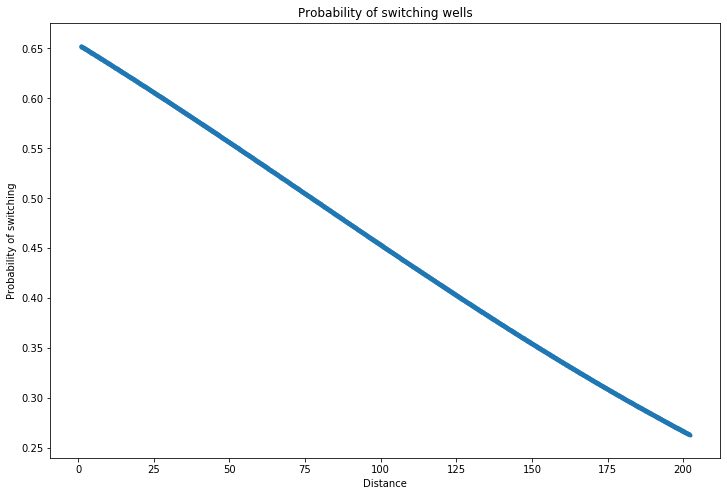

In [247]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)
plt.scatter(plot_x, plot_y, marker='.')
plt.xlabel("Distance")
plt.ylabel("Probability of switching")
plt.title("Probability of switching wells")
plt.show()

3\. Interpreting logistic regression coefficients: Use the “rule-of-4” discussed in class on Thursday, to interpret the solution: what can you say about the change in the probability of switching wells, for every additional 100 meters of distance?

The coefficient for the distance to the nearest well is -0.008240. Using the "rule-of-4" to interpret it, we can see an upper bound of 0.206.<br>
Let's see in the math.
$$H(x) = \frac{1}{1+e^{-x^T\beta}}$$
Suppose that $x_1$ denotes the distance feature and $\beta_1$ denotes coefficient for $x_1$.
$$
\begin{equation}
\begin{aligned}
\frac{\partial{H(x)}}{\partial{x_1}} & = \frac{e^{-x^T\beta}}{(1+e^{-x^T\beta})^2}\frac{\partial{x^T\beta}}{\partial{x_1}} \\
& = \frac{e^{-x^T\beta}}{(1+e^{-x^T\beta})^2}\beta_1
\end{aligned}
\end{equation}
$$
Observed from the  plot of sigmod function, we can find that when $X^T\beta=0$ the sigmod function has the biggest value of derivative (sharpest change in y). To have the upper bound, set $X^T\beta = 0$. Upper bound for influence of distance feature in probability is
$$
\begin{equation}
\begin{aligned}
\frac{\partial{H(x)}}{\partial{x_1}}|_{X^T\beta=0} & = \beta_1/4 \\
\frac{H(x+\Delta x_1) - H(x)}{\Delta x_1} & \leq \beta_1/4
\end{aligned}
\end{equation}$$
Here, $H(x)$ denotes the probability to switch when $X=x$, which means $p(x+\Delta x_1)-p(x) \leq \frac{\beta_1 \Delta x_1}{4}$.<br>
So, the decrease in the probability of switching wells for every additional 100 meters of distance is less than 0.206.

4\. Now solve a logistic regression incorporating the constant term, the distance and also arsenic levels. Report the coefficients

In [248]:
# The constant term here is the same as the offset term mentioned before, in other words, beta0. 
# So, in this problem, we still use the intercept generated by the Logistic Regression as the constant term.
X_da_train = X_train[:, [1, 0]]
X_da_test = X_test[:, [1, 0]]
# Specifies if a constant namely an offset term should be added to the decision function.
LR2 = LogisticRegression(fit_intercept=True)
LR2.fit(X_da_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [251]:
# Report the coefficients
print("The parameters for the logistic regression model (constant term, distance, arsenic level): ")
print("The constant term (intercept): %f" % LR2.intercept_)
print("Coefficient for the distance to the nearest safe well: %f" % LR2.coef_[0][0])
print("Coefficient for the arsenic level: %f" % LR2.coef_[0][1])

The parameters for the logistic regression model (constant term, distance, arsenic level): 
The constant term (intercept): -0.008928
Coefficient for the distance to the nearest safe well: -0.011540
Coefficient for the arsenic level: 0.494415


5\. Next we want to answer the question of which factor is more significant, distance, or arsenic levels? This is not a well specified question, since these two features have different units.
One natural choice is to ask if after normalizing by the respective standard deviations of each feature, if moving one unit in one (normalized) feature predicts a larger change in probability of switching wells, than moving one unit in the other (also normalized) feature. Use this reasoning to answer the question.

In [252]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
std_scaler.fit(X_da_train)
X_da_train_std = std_scaler.transform(X_da_train)
X_da_test_std = std_scaler.transform(X_da_test)

In [253]:
LR2_std = LogisticRegression(fit_intercept=True)
LR2_std.fit(X_da_train_std, y_train)
# Report the coefficients
print("The parameters for the logistic regression model with standardized features (constant term, distance, arsenic level): ")
print("The constant term (intercept): %f" % LR2_std.intercept_)
print("Coefficient for the distance to the nearest safe well: %f" % LR2_std.coef_[0][0])
print("Coefficient for the arsenic level: %f" % LR2_std.coef_[0][1])

The parameters for the logistic regression model with standardized features (constant term, distance, arsenic level): 
The constant term (intercept): 0.281021
Coefficient for the distance to the nearest safe well: -0.398157
Coefficient for the arsenic level: 0.542897


After the standardization, different features fit into the same range of [0, 1]. Then, we can compare the significance of different features using the "rule-of-4". To see from the cofficients, we can find that moving one unit in arsenic level (normalized) predicts a larger change in probability of switching wells (upper bound is 0.542897/4 = 0.1357) than in the distance (normalized) with upper bound of -0.0995.

6\. Now consider all the features in the data set. Also consider adding interaction terms among all features that have a large main effect. Use cross validation to build the best model you can (using your training set only), and then report the test error of your best model.

In [254]:
std_scaler_all = StandardScaler()
std_scaler_all.fit(X_train)
X_train_std = std_scaler_all.transform(X_train)
X_test_std = std_scaler_all.transform(X_test)

In [255]:
LRall_std = LogisticRegression(fit_intercept=True)
LRall_std.fit(X_train_std, y_train)
# Report the coefficients
print("The parameters for the logistic regression model with all standardized features: ")
print("The constant term (intercept): %f" % LRall_std.intercept_)
print("Coefficient for the arsenic level: %f" % LRall_std.coef_[0][0])
print("Coefficient for the distance to the nearest safe well: %f" % LRall_std.coef_[0][1])
print("Coefficient for the community involvement: %f" % LRall_std.coef_[0][2])
print("Coefficient for the education level: %f" % LRall_std.coef_[0][3])

The parameters for the logistic regression model with all standardized features: 
The constant term (intercept): 0.283687
Coefficient for the arsenic level: 0.543979
Coefficient for the distance to the nearest safe well: -0.395755
Coefficient for the community involvement: -0.098071
Coefficient for the education level: 0.122951


In [260]:
# Seeing from the results above, the most 2 affective factors is arsenic level and distance. Add arsenic level * distance as a new feature.
X_train_int = np.c_[X_train, X_train[:, 0]*X_train[:, 1]]
X_test_int = np.c_[X_test, X_test[:, 0]*X_test[:, 1]]
std_scaler_int = StandardScaler()
std_scaler_int.fit(X_train_int)
X_train_int_std = std_scaler_int.transform(X_train_int)
X_test_int_std = std_scaler_int.transform(X_test_int)

In [264]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
LRCV = LogisticRegressionCV(cv = 5, scoring='accuracy')
LRCV.fit(X_train_int_std, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True,
                     scoring='accuracy', solver='lbfgs', tol=0.0001, verbose=0)

In [267]:
# Report the coefficients
print("The parameters for the logistic regression model with interaction term: ")
print("The constant term (intercept): %f" % LRCV.intercept_)
print("Coefficient for the arsenic level: %f" % LRCV.coef_[0][0])
print("Coefficient for the distance to the nearest safe well: %f" % LRCV.coef_[0][1])
print("Coefficient for the community involvement: %f" % LRCV.coef_[0][2])
print("Coefficient for the education level: %f" % LRCV.coef_[0][3])
print("Coefficient for the interation term (arsenic level * distance): %f" % LRCV.coef_[0][4])

The parameters for the logistic regression model with interaction term: 
The constant term (intercept): 0.277906
Coefficient for the arsenic level: 0.508429
Coefficient for the distance to the nearest safe well: -0.301406
Coefficient for the community involvement: -0.089695
Coefficient for the education level: 0.108715
Coefficient for the interation term (arsenic level * distance): -0.076455


In [269]:
# Test error of the best model.
accuracy = accuracy_score(y_test, LRCV.predict(X_test_int_std))
print("The accuracy score of the best model is %f"%accuracy)
print("The test error of the best model is %f"%(1-accuracy))

The accuracy score of the best model is 0.605487
The test error of the best model is 0.394513


7\. (Optional) Now also play around with $l_1$ and $l_2$ regularization, and try to build the most accurate model you can (accuracy computed on the test data).